In [2]:
from Engine.Backtester.Broker import Broker
from Engine.Backtester.Orders import MKT, LMT, TRAIL_LMT, ADAPT
from Engine.Backtester.Statistics import Statistics
from Engine.Backtester.Exchange import Exchange

import pandas as pd
import pandas_ta as ta
import os

In [12]:
class Algos:
    def __init__(self, num):
        self.num = num
        self.__setup_func = getattr(self, f'setup{num}')
        self.__algo_func = getattr(self, f'algo{num}')
    
    def setup0(self, df):
        return df

    def algo0(self, **var):
        return None

    def setup1(self, df):
        return df
    
    def algo1(self, **var):
        if var["new_stock"]:
            return [LMT(int((var["balance"] // var["price"]) - 1), var["price"])]


    def send_setup(self, df):
        """
        Add columns/indicators to calculate before the run in order to save time

        Inputs
        :df (pd.DataFrame) The DataFrame containing OHLC (Open, High, Low, Close), Adj Close and Volume

        Output
        :df (pd.DataFrame) Same DataFrame with more columns and/or indicators
        """
        return self.__setup_func(df)

    def send_algo(self, **var):
        """
        Get values from the environment

        Inputs (var)
        :df (pd.DataFrame)            The DataFrame containing all values upto current bar
        :current_tick (dict)          Current bar and it's fields
        :price (float)                'close' field from current bar in df
        :initial_day_balance (float)  Money in the account at the beginning of the day
        :balance (float)              Cash spendable
        :bought_market_value (float)  market_value at time of last buy (shares * price)
        :market_value(float)          Shares * Price
        :shares (integer)             Position    
        :new_stock (bool)             True if it is the start of a file

        Output
        :Order (class) An order class from Engine/Orders.py
        """
        return self.__algo_func(**var)


def print_output(results):
    for key in results.keys():
        print(f"{key}".title().ljust(15, " ") + f": {results[key]}")
    print()

filepath = "Data/day_after_5_percent_rise"
Algorithm = Algos("1")

file_count = len(os.listdir(filepath))
stages = [
    (filepath, file_count // 2),
    (filepath, file_count)
]

runs = []

for stage in stages:
    exchange_feed = Exchange(
        filepath=stage[0],
        limit=stage[1],
        lazy_loading=True,
        lazy_loading_limit=5,
        slippage=1)
    
    broker = Broker(
        cash=5000, algorithm=Algorithm,
        trade_cost=2, exchange_feed=exchange_feed
    )
    
    broker.simulate(
        show_info=False,
        show_warnings=False,
        show_progress=True
    )

    results = broker.get_results()
    # cash_needed = results["initial cash"]
    cash_needed = results["initial cash"] * (1.005 ** stage[1])

    print_output(results)
    print(f"{cash_needed:.2f}")
    runs.append((broker, results))

    if (results['final cash'] / cash_needed) <= 1:
        break

13/13
Initial Cash   : 5000
Final Cash     : 5479.52
Time Taken     : 0.21
Candles/Second : 23870.49

5334.93
26/26
Initial Cash   : 5000
Final Cash     : 5497.11
Time Taken     : 0.38
Candles/Second : 26396.21

5692.30


EXTRA INFORMATION
%Mean          : 0.4178
Sortino        : 21.0815



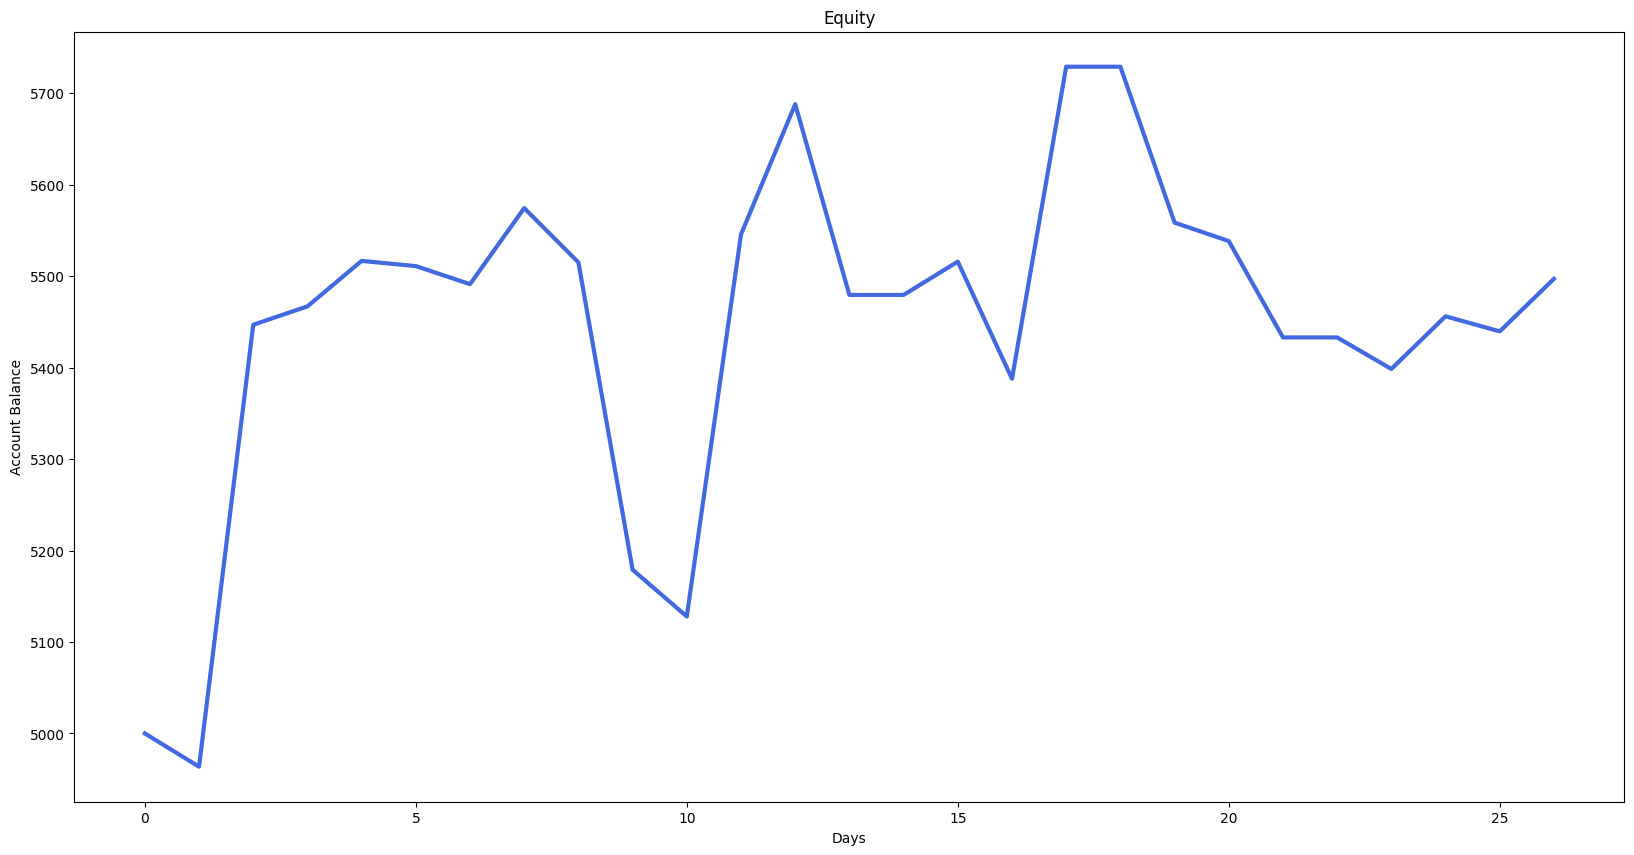

[]


In [10]:
statistics = Statistics(runs[-1][0])

print("EXTRA INFORMATION")
print_output(statistics.get_statistics())

statistics.cash_graph("linear")

outliers = statistics.get_outliers()
print(outliers)
# statistics.plot_sub_file_trades(outliers, include=["small_rolling", "long_rolling"])
statistics.plot_sub_file_trades(outliers, include=[])